# COMS W4995 DL4CV Final Project - Visual Question Answering network using FiLM layers and SBERT

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from collections import namedtuple
from PIL import Image
import copy

from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from random import randint

from sentence_transformers import SentenceTransformer, models, InputExample, losses, evaluation


# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
import os
import sys
import json
import pickle

import nltk
import tqdm
from torchvision import transforms
from PIL import Image

cuda:0


## Data preprocessing

In [7]:
# download the dataset
!kaggle datasets download -d dcairoli/vqadrawing

 99%|██████████████████████████████████████▊| 3.95G/3.97G [00:34<00:00, 123MB/s]
100%|███████████████████████████████████████| 3.97G/3.97G [00:34<00:00, 124MB/s]


In [2]:
import json
with open('VQA_Dataset/train_questions_annotations.json') as json_file:
    data = json.load(json_file)

In [3]:
data = list(data.values())

In [11]:
data[65]

{'question': 'Is the sun shining?', 'image_id': '9871', 'answer': 'yes'}

In [13]:
# create data
embedder = SentenceTransformer('all-mpnet-base-v2')
result = []
word_index = 1
answer_index = 0
answer_dic = {}
for i in range(len(data)):
    response = data[i]['answer']
    image = data[i]['image_id']
    question = data[i]['question']
    question_embedding = embedder.encode(question, convert_to_tensor=True).to('cpu')
    if len(response.split(','))>1:
        for j in range(len(response.split(','))):
            if j==0:
                answer_word = str(response.split(',')[j]).lower()
            else:
                answer_word = str(response.split(',')[j][1:]).lower()
            try:
                answer = answer_dic[answer_word]
            except:
                answer = answer_index
                answer_dic[answer_word] = answer_index
                answer_index += 1
            result.append((image,question,question_embedding,answer,response))
    else:
        answer_word = str(response).lower()
        try:
            answer = answer_dic[answer_word]
        except:
            answer = answer_index
            answer_dic[answer_word] = answer_index
            answer_index += 1
        result.append((image,question,question_embedding,answer,response))

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [14]:
with open('data.pickle', 'wb') as handle:
    pickle.dump(result, handle)

In [4]:
# get answer space
answer_index = 0
answer_dic = {}
for i in range(len(data)):
    response = data[i]['answer']
    if len(response.split(','))>1:
        for j in range(len(response.split(','))):
            if j==0:
                answer_word = str(response.split(',')[j]).lower()
            else:
                answer_word = str(response.split(',')[j][1:]).lower()
            try:
                answer = answer_dic[answer_word]
            except:
                answer = answer_index
                answer_dic[answer_word] = answer_index
                answer_index += 1
    else:
        answer_word = str(response).lower()
        try:
            answer = answer_dic[answer_word]
        except:
            answer = answer_index
            answer_dic[answer_word] = answer_index
            answer_index += 1

answer_dic
answer_space = list(answer_dic.keys())
answer_space

['man',
 'blanket',
 'bench',
 'yes',
 'no',
 'brown',
 '1',
 'gray',
 'soccer',
 '3',
 'playing',
 'sitting',
 'food',
 '2',
 'orange',
 'red',
 'yellow',
 'blue',
 'baseball',
 'nothing',
 'dog',
 'tree',
 'stool',
 '0',
 'woman',
 'log',
 'bike',
 'floor',
 '4',
 'table',
 'standing',
 'sleeping',
 'plant',
 'apple',
 'black',
 'squirrel',
 'grass',
 'left',
 'bone',
 'girl',
 'white',
 '5',
 'wine',
 'couch',
 'sandbox',
 'chair',
 'cat',
 'pie',
 'watermelon',
 'book',
 'green',
 'monkey bars',
 'boy',
 'right',
 'rug',
 'football',
 'sunny',
 'bird']

## Construct dataloaders

In [5]:
# if data.pickle exists
with open('data.pickle', 'rb') as handle:
    data=pickle.load(handle)

In [6]:
len(data)

58832

In [7]:
import random
print(len(data))

split = int(len(data)*0.8)
print(split)

random.shuffle(data)
dev_data = data[:split]
test_data = data[split:]

split = int(len(dev_data)*0.8)
print(split)
train_data = dev_data[:split]
val_data = dev_data[split:]

58832
47065
37652


In [8]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

37652
9413
11767


In [9]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

from torchvision import transforms as T

class DRAW(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        imgfile, question, question_embedding, answer_label, response = self.data[index]
        img = Image.open(os.path.join('VQA_Dataset/Images', imgfile+'.png')).convert('RGB')
        img = self.transform(img)

        return img, question_embedding, question, answer_label

    def __len__(self):
        return len(self.data)

from torchvision import transforms as T
transform = T.Compose([
    T.Resize(224),
    T.Pad(4),
    T.RandomCrop([224, 224]),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
])

In [26]:
train_loader = torch.utils.data.DataLoader(DRAW(data=train_data, transform=transform), batch_size=12, shuffle=True)
training_loader_iter = iter(train_loader)
img, question_embedding, question, answer_label = next(training_loader_iter)
img = img.to(device)
answer_label = answer_label.to(device)
question_embedding = question_embedding.to(device)

## Network Architecture

In [10]:
from torchvision.models import resnet101, ResNet101_Weights
import torchvision
import torch

In [31]:
print(torchvision.__version__)

0.13.1+cu113


In [11]:
SENTENCE_TRANSFORMER_DIM = 384
SENTENCE_TRANSFORMER_DIM = 768

class CNN(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(CNN, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, 4, 2, 1)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(output_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        

        return x

class stem(nn.Module):
    def __init__(self, in_channels=1024, out_channels=128):
        super(stem, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        return x

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.model = nn.Sequential(
            CNN(3, 128),
            CNN(128, 128),
            CNN(128, 128),
            CNN(128, 128),
        )
    def forward(self, x):
        return self.model(x)

class FeatureExtractor_resnet(nn.Module):
    def __init__(self):
        super(FeatureExtractor_resnet, self).__init__()
        self.cnn = getattr(torchvision.models, 'resnet101')(pretrained=True)
        self.layers = [
            self.cnn.conv1,
            self.cnn.bn1,
            self.cnn.relu,
            self.cnn.maxpool,
        ]
        for i in range(3):
            name = 'layer%d' % (i + 1)
            self.layers.append(getattr(self.cnn, name))
        self.model = torch.nn.Sequential(*self.layers)
        #model.cuda()
        self.model.eval()
        #print(model)
        
    def forward(self, x):
        return self.model(x)

class FiLMBlock(nn.Module):
    def __init__(self):
        super(FiLMBlock, self).__init__()
        

    def forward(self, input, gamma_beta):
        # b, ch, h, w = input.size()
        batch =  input.size()[0]
        height = input.size()[2]
        width = input.size()[3]
        features = input.size()[1]
        # context_dim = context.size()[1]
        gamma_beta = gamma_beta.unsqueeze(-1).unsqueeze(-1) # shape: [b, 2*ch, 1, 1]
        gamma = gamma_beta[:,:features,:,:] # shape: [b, ch, 1, 1]
        # print('gamma size should be [1,128,1,1]')
        # print(gamma.size())
        beta = gamma_beta[:,features:,:,:] # shape: [b, ch, 1, 1]
        # print('beta size should be [1,128,1,1]')
        # print(beta.size())
        output = gamma * input + beta

        return output


class Classifier(nn.Module):
    def __init__(self, n_classes, prev_channels=128):
        super(Classifier, self).__init__()
        self.conv = nn.Conv2d(prev_channels, 512, 1, 1, 0)
        self.relu = nn.ReLU(inplace=True)
        self.global_max_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.mlp = nn.Sequential(nn.Linear(512, 1024),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(1024, 1024),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(1024, n_classes))
    def forward(self, x):
        x = self.conv(x)
        x = self.global_max_pool(x)
        x = x.view(x.size(0), x.size(1))
        x = self.mlp(x)

        return x

class resblock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(resblock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.film = FiLMBlock()
        self.relu2 = nn.ReLU(inplace=True)
        self.film_generator = nn.Linear(SENTENCE_TRANSFORMER_DIM, out_channels * 2 ) # 

    def forward(self, x, context):
        
        # print(context.type())
        film_params = self.film_generator(context) # shape: [b, num_filters * 2]
        # print('film params size should be [1,256]')
        # print(film_params.size())
        x = self.conv1(x)
        x = self.relu1(x)
        identity = x

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.film(x, film_params)
        x = self.relu2(x)

        x = x+identity # instead of x+=identity because this one is inplace operation
        return x

class FiLM(nn.Module):
    def __init__(self, n_vocab=58, n_resblock=4):
        super(FiLM, self).__init__()
        self.stem = stem()
        self.resblocks = nn.ModuleList()
        for i in range(n_resblock):
            self.resblocks.append(resblock(128,128))
        self.classifier = Classifier(n_classes = n_vocab)
        # self.stem=build_stem

    def forward(self, fe_image, question):
        img = self.stem(fe_image)
        for i, resblock in enumerate(self.resblocks):
            img = resblock(img, question)
            # print(img.size())
        out = self.classifier(img)
        # print(out.size())
        return out

## Training

### WUPS Metric Implementation

In [12]:
import sys

#import enchant

from numpy import prod
from nltk.corpus import wordnet as wn
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')


def file2list(filepath):
    with open(filepath,'r') as f:
        lines =[k for k in 
            [k.strip() for k in f.readlines()] 
        if len(k) > 0]

    return lines


def list2file(filepath,mylist):
    mylist='\n'.join(mylist)
    with open(filepath,'w') as f:
        f.writelines(mylist)


def items2list(x):
    """
    x - string of comma-separated answer items
    """
    return [l.strip() for l in x.split(',')]


def fuzzy_set_membership_measure(x,A,m):
    """
    Set membership measure.
    x: element
    A: set of elements
    m: point-wise element-to-element measure m(a,b) ~ similarity(a,b)

    This function implments a fuzzy set membership measure:
        m(x \in A) = max_{a \in A} m(x,a)}
    """
    return 0 if A==[] else max(map(lambda a: m(x,a), A))


def score_it(A,T,m):
    """
    A: list of A items 
    T: list of T items
    m: set membership measure
        m(a \in A) gives a membership quality of a into A 

    This function implements a fuzzy accuracy score:
        score(A,T) = min{prod_{a \in A} m(a \in T), prod_{t \in T} m(a \in A)}
        where A and T are set representations of the answers
        and m is a measure
    """
    if A==[] and T==[]:
        return 1

    # print A,T

    score_left=0 if A==[] else prod(map(lambda a: m(a,T), A))
    score_right=0 if T==[] else prod(map(lambda t: m(t,A),T))
    return min(score_left,score_right) 


# implementations of different measure functions
def dirac_measure(a,b):
    """
    Returns 1 iff a=b and 0 otherwise.
    """
    if a==[] or b==[]:
        return 0.0
    return float(a==b)


def wup_measure(a,b,similarity_threshold=0.8):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wn.synsets(a,pos=wn.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a) 
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score 


[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Training Loop

In [13]:
def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.sum(wup_scores)


def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=2, val_tolerance=2):
    since = time.time()
    FE = FeatureExtractor_resnet().to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_val_loss = [np.Inf] * val_tolerance
    early_stop = False

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_wups = 0.0

            # Iterate over data.
            with tqdm.tqdm(dataloaders[phase], unit='batch') as tepoch:
                for img, question_embedding, question, answer in tepoch:
                    img = img.to(device)
                    answer = answer.to(device)
                    question_embedding = question_embedding.to(device)
                    context = question_embedding
                    img = FE(img)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(img,question_embedding)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, answer)
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * img.size(0)
                    running_corrects += torch.sum(preds == answer.data)
                    running_wups += batch_wup_measure(answer.data, preds)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_wups = running_wups / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} WUPS: {epoch_wups:.4f}')

            # deep copy the model
            if phase == 'val': 
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                worst_loss = max(best_val_loss)
                if epoch_loss > worst_loss:
                    early_stop = True
                    break
                else:
                    best_val_loss[np.argmax(best_val_loss)] = epoch_loss
        print(best_val_loss)
        if early_stop:
            print("Training early stopped")
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [40]:
from torch.optim import lr_scheduler

model = FiLM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


criterion = nn.CrossEntropyLoss()

batch_size = 32

train_loader = torch.utils.data.DataLoader(DRAW(data=train_data, transform=transform), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(DRAW(data=val_data, transform=transform), batch_size=batch_size, shuffle=True)
dataloaders_dict = {'train':train_loader,'val':val_loader}
dataset_sizes = {'train': len(train_data), 'val': len(val_data)}

model_ft = train_model(model, dataloaders_dict, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=20, val_tolerance=5)

Epoch 0/19
----------


100%|██████████| 1177/1177 [18:18<00:00,  1.07batch/s]


train Loss: 1.3622 Acc: 0.4688 WUPS: 0.6351


100%|██████████| 295/295 [02:34<00:00,  1.91batch/s]


val Loss: 1.1525 Acc: 0.5340 WUPS: 0.6815
[1.152493347317965, inf, inf, inf, inf]
Epoch 1/19
----------


100%|██████████| 295/295 [02:35<00:00,  1.90batch/s]s]


val Loss: 1.0467 Acc: 0.5768 WUPS: 0.7202
[1.152493347317965, 1.0466859032544702, inf, inf, inf]
Epoch 2/19
----------


100%|██████████| 1177/1177 [18:21<00:00,  1.07batch/s]


train Loss: 0.9698 Acc: 0.5851 WUPS: 0.7319


100%|██████████| 295/295 [02:37<00:00,  1.87batch/s]


val Loss: 0.9851 Acc: 0.5867 WUPS: 0.7377
[1.152493347317965, 1.0466859032544702, 0.98512948632025, inf, inf]
Epoch 3/19
----------


100%|██████████| 1177/1177 [18:22<00:00,  1.07batch/s]


train Loss: 0.9149 Acc: 0.6110 WUPS: 0.7543


100%|██████████| 295/295 [02:39<00:00,  1.85batch/s]


val Loss: 0.9860 Acc: 0.5929 WUPS: 0.7437
[1.152493347317965, 1.0466859032544702, 0.98512948632025, 0.9860179554981721, inf]
Epoch 4/19
----------


100%|██████████| 1177/1177 [18:26<00:00,  1.06batch/s]


train Loss: 0.8754 Acc: 0.6300 WUPS: 0.7706


100%|██████████| 295/295 [02:37<00:00,  1.87batch/s]


val Loss: 0.9646 Acc: 0.6041 WUPS: 0.7444
[1.152493347317965, 1.0466859032544702, 0.98512948632025, 0.9860179554981721, 0.9645542593459755]
Epoch 5/19
----------


100%|██████████| 1177/1177 [18:10<00:00,  1.08batch/s]


train Loss: 0.8576 Acc: 0.6420 WUPS: 0.7801


100%|██████████| 295/295 [02:36<00:00,  1.88batch/s]


val Loss: 0.9562 Acc: 0.6080 WUPS: 0.7523
[0.956210380277813, 1.0466859032544702, 0.98512948632025, 0.9860179554981721, 0.9645542593459755]
Epoch 6/19
----------


100%|██████████| 1177/1177 [18:07<00:00,  1.08batch/s]


train Loss: 0.8117 Acc: 0.6612 WUPS: 0.7953


100%|██████████| 295/295 [02:34<00:00,  1.91batch/s]


val Loss: 0.9518 Acc: 0.6253 WUPS: 0.7643
[0.956210380277813, 0.9518143156693565, 0.98512948632025, 0.9860179554981721, 0.9645542593459755]
Epoch 7/19
----------


100%|██████████| 1177/1177 [18:02<00:00,  1.09batch/s]


train Loss: 0.7021 Acc: 0.7063 WUPS: 0.8282


100%|██████████| 295/295 [02:33<00:00,  1.92batch/s]


val Loss: 0.9424 Acc: 0.6335 WUPS: 0.7699
[0.956210380277813, 0.9518143156693565, 0.98512948632025, 0.9423781541307433, 0.9645542593459755]
Epoch 8/19
----------


100%|██████████| 1177/1177 [18:03<00:00,  1.09batch/s]


train Loss: 0.6696 Acc: 0.7201 WUPS: 0.8393


100%|██████████| 295/295 [02:33<00:00,  1.92batch/s]


val Loss: 0.9531 Acc: 0.6307 WUPS: 0.7698
[0.956210380277813, 0.9518143156693565, 0.9530520870178244, 0.9423781541307433, 0.9645542593459755]
Epoch 9/19
----------


100%|██████████| 1177/1177 [18:03<00:00,  1.09batch/s]


train Loss: 0.6494 Acc: 0.7302 WUPS: 0.8468


100%|██████████| 295/295 [02:34<00:00,  1.91batch/s]

val Loss: 0.9769 Acc: 0.6308 WUPS: 0.7702
[0.956210380277813, 0.9518143156693565, 0.9530520870178244, 0.9423781541307433, 0.9645542593459755]
Training early stopped
Training complete in 208m 6s
Best val Acc: 0.633486


## Evaluation

### Plotting training info

Here all info is hardcoded as shown in the training loop information print above. They are true and accurate.

In [1]:
train_acc = [0.4688, 0.5193, 0.5851, 0.6110, 0.6300, 0.6420, 0.6612, 0.7063, 0.7201, 0.7302]
val_acc = [0.5340, 0.5768, 0.5867, 0.5929, 0.6041, 0.6080, 0.6253, 0.6335, 0.6307, 0.6308]
train_loss = [1.3622, 1.055, 0.9698, 0.9149, 0.8754, 0.8576, 0.8117, 0.7021, 0.6696, 0.6494]
val_loss = [1.1525, 1.0467, 0.9851, 0.9860, 0.9646, 0.9562, 0.9518, 0.9424, 0.9531, 0.9769]
train_wups = [0.6351, 0.654, 0.7319, 0.7543, 0.7706, 0.7801, 0.7953, 0.8282, 0.8393, 0.8468]
val_wups = [0.6815, 0.7202, 0.7377, 0.7437, 0.7444, 0.7523, 0.7643, 0.7699, 0.7698, 0.7702]

In [2]:
import matplotlib.pyplot as plt

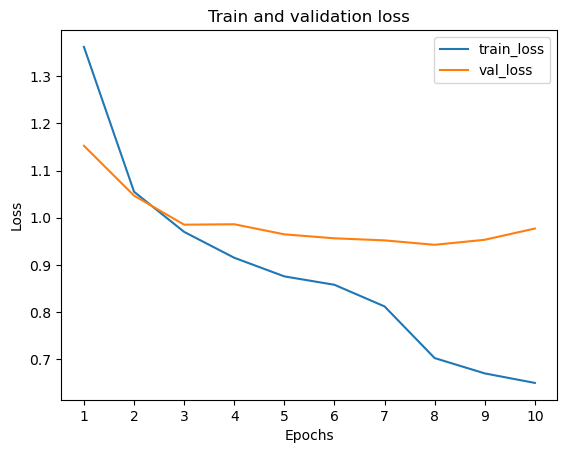

In [42]:
fig = plt.figure()
rangez = np.arange(1,11)
plt.plot(rangez, train_loss, label='train_loss')
plt.plot(rangez, val_loss, label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(rangez)
plt.title('Train and validation loss')
plt.show()

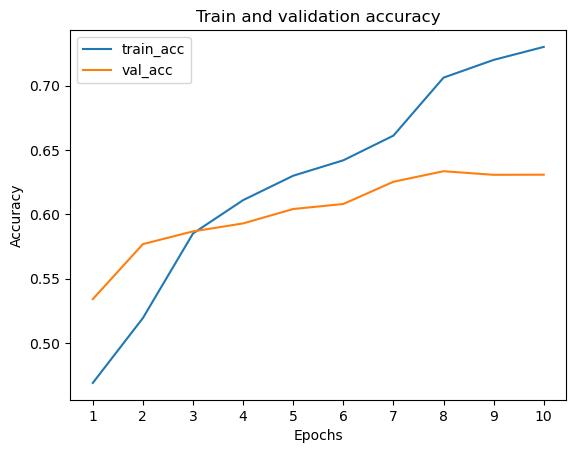

In [43]:
fig = plt.figure()
rangez = np.arange(1,11)
plt.plot(rangez, train_acc, label='train_acc')
plt.plot(rangez, val_acc, label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(rangez)
plt.title('Train and validation accuracy')
plt.show()

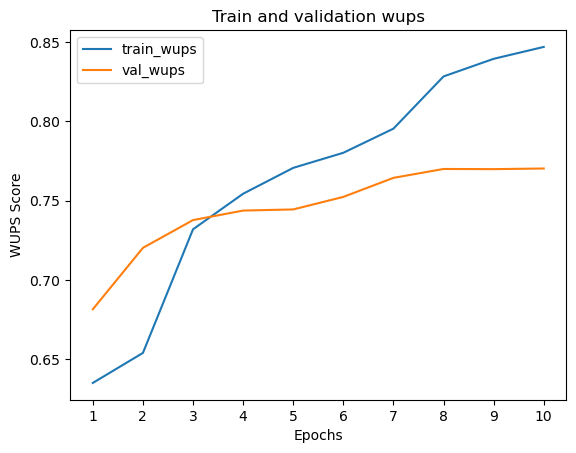

In [44]:
fig = plt.figure()
rangez = np.arange(1,11)
plt.plot(rangez, train_wups, label='train_wups')
plt.plot(rangez, val_wups, label='val_wups')
plt.xlabel('Epochs')
plt.ylabel('WUPS Score')
plt.legend()
plt.xticks(rangez)
plt.title('Train and validation wups')
plt.show()

### Evaluate both metrics on test set

In [18]:
test_loader = torch.utils.data.DataLoader(DRAW(data=test_data, transform=transform), batch_size=64, shuffle=True)

In [19]:
len(test_data)

11767

In [17]:
criterion = nn.CrossEntropyLoss()

batch_size = 32
running_loss = 0.0
running_corrects = 0
running_wups = 0.0
with tqdm.tqdm(test_loader, unit='batch') as tepoch:
    for img, question_embedding, question, answer in tepoch:
        img = img
        answer = answer.to(device)
        question_embedding = question_embedding.to(device)
        context = question_embedding
        img = FE(img).to(device)

        # forward
        # track history if only in train
        outputs = model(img,question_embedding)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, answer)

        # statistics
        running_loss += loss.item() * img.size(0)
        running_corrects += torch.sum(preds == answer.data)
        running_wups += batch_wup_measure(answer.data, preds)


100%|██████████| 736/736 [25:08<00:00,  2.05s/batch]


NameError: name 'dataset_sizes' is not defined

In [21]:
epoch_loss = running_loss / len(test_data)
epoch_acc = running_corrects.double() / len(test_data)
epoch_wups = running_wups / len(test_data)

print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} WUPS: {epoch_wups:.4f}')

Loss: 0.7624 Acc: 0.6938 WUPS: 0.8166
